<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [2]:
# %matplotlib widget
%matplotlib inline

In [3]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.3 MB/s eta 0:00:00


# Gaussian Process

In [3]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [4]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=20


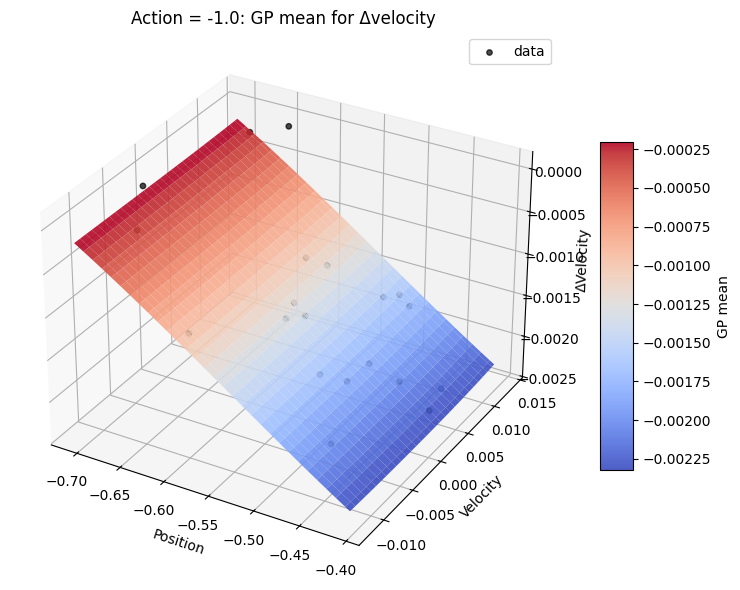

Plotting for action a=0.0
Values near action a=0.0 n=35


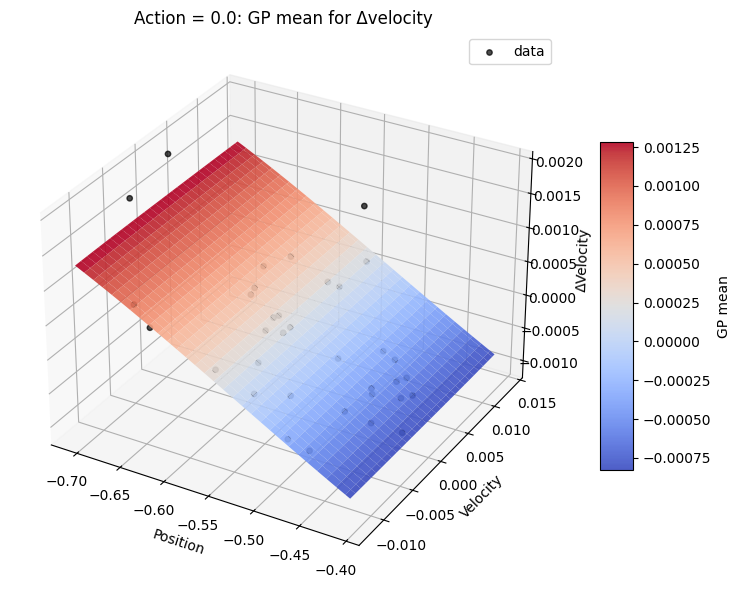

Plotting for action a=1.0
Values near action a=1.0 n=12


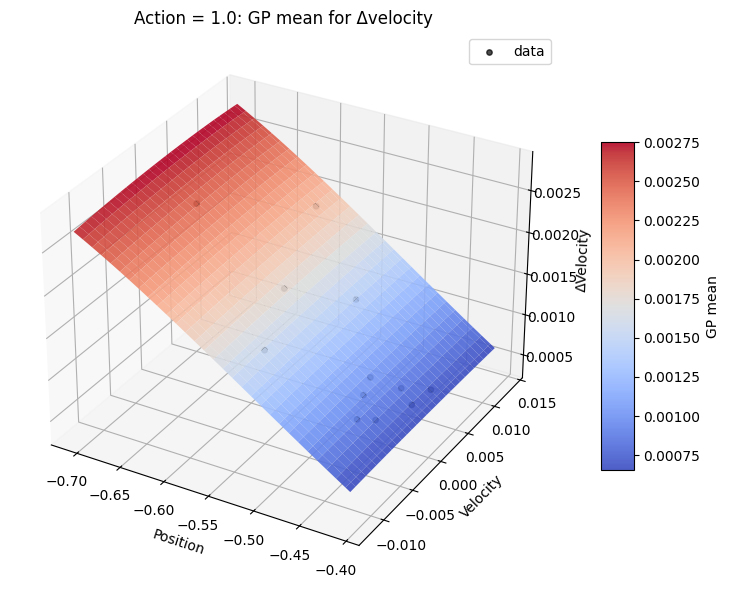

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=20


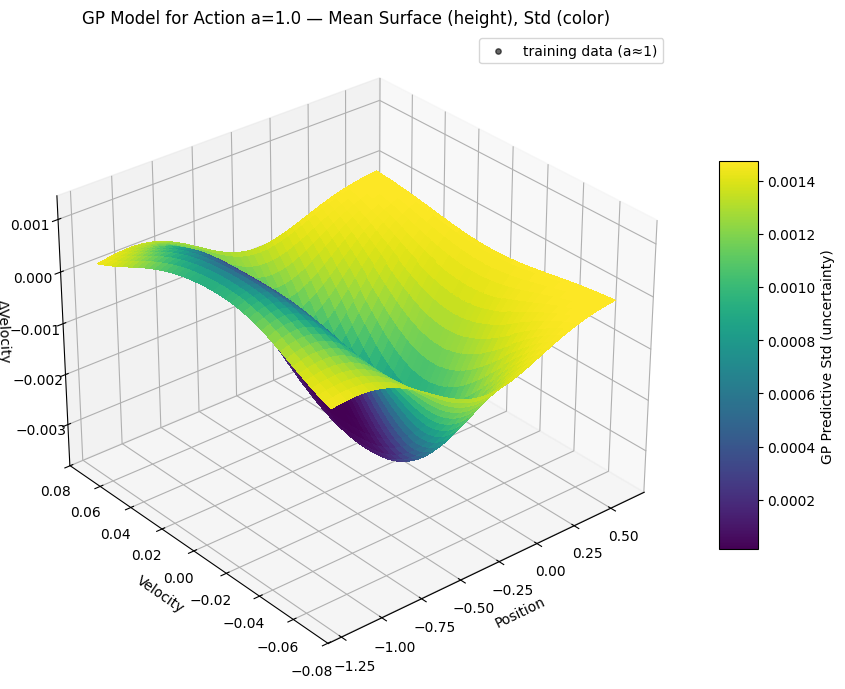

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


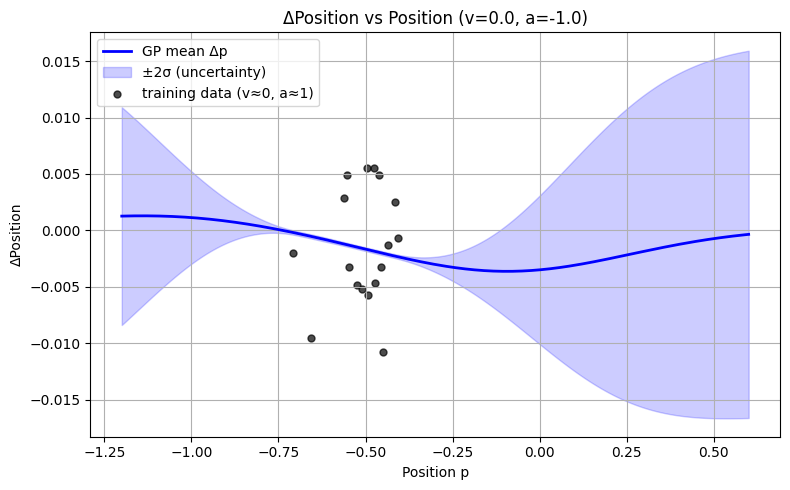

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


Collected 150 samples. X shape=(150, 3), Y shape=(150, 2)
Trained GP[0] (Δpos) and GP[1] (Δvel).
Sanity test — rollout length=6, cost=18.809


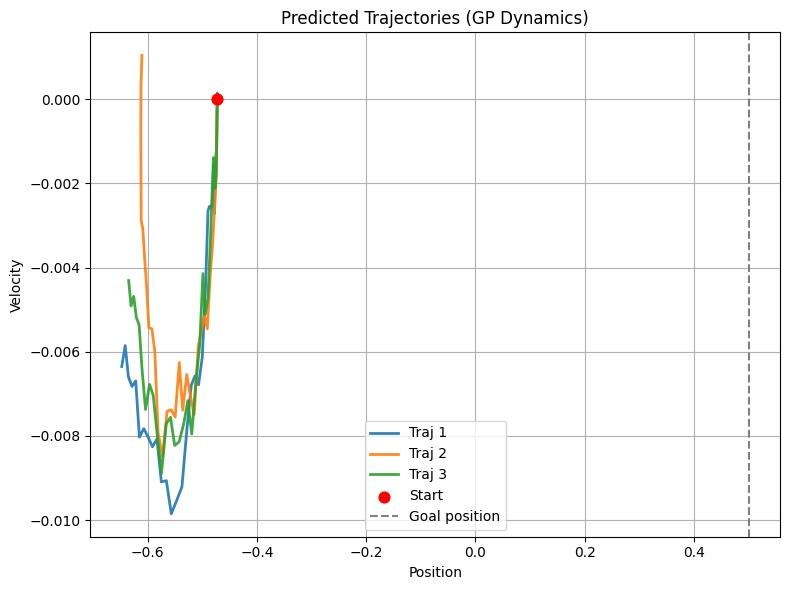

t=  0  obs=[-4.7250926e-01  9.8388213e-05]  a=+0.320


In [ ]:
# ============================================================
# GP + MPPI for MountainCarContinuous-v0 (Gymnasium+GPyTorch)
# ============================================================

import os
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import gymnasium as gym

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

# -----------------------------
# Environment
# -----------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

POS_LOW, POS_HIGH = env.observation_space.low[0],  env.observation_space.high[0]
VEL_LOW, VEL_HIGH = env.observation_space.low[1],  env.observation_space.high[1]
ACT_LOW, ACT_HIGH = env.action_space.low[0],       env.action_space.high[0]

# ============================================================
# 1) GPyTorch GP model + Manager
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class GPManager:
    """
    Wraps an ExactGP for 1D target (single output).
    Handles normalization, training, prediction, and incremental data.
    """
    def __init__(self, kernel='RBF', lr=0.03, iters=600):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False

        self.X_train = None
        self.Y_train = None

        self.X_mean = None
        self.X_std  = None
        self.Y_mean = None
        self.Y_std  = None

        self.likelihood = None
        self.model = None

    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32).flatten()

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self._compute_normalization()
        self._train_model()
        self.trained = True

    def add_data(self, X_new, Y_new, retrain=True):
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()

        if self.X_train is None:
            self.X_train = X_new
            self.Y_train = Y_new
        else:
            self.X_train = torch.cat([self.X_train, X_new], dim=0)
            self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self._compute_normalization()
            self._train_model()
            self.trained = True

    def _compute_normalization(self, eps=1e-8):
        X = self.X_train
        Y = self.Y_train

        X_mean = X.mean(dim=0)
        X_std  = X.std(dim=0)
        X_std  = torch.clamp(X_std, min=eps)

        Y_mean = float(Y.mean(dim=0))
        Y_std  = float(Y.std(dim=0))
        if Y_std < eps:
            Y_std = 1.0  # avoid divide-by-zero; degenerate target not expected here

        self.X_mean, self.X_std = X_mean, X_std
        self.Y_mean, self.Y_std = Y_mean, Y_std

        self.Xn = (X - X_mean) / X_std
        self.Yn = (Y - Y_mean) / Y_std

    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        # small initial noise; GP will learn it
        self.likelihood.noise_covar.initialize(noise=1e-3)

        self.model = ExactGPModel(
            self.Xn, self.Yn, self.likelihood,
            kernel=self.kernel,
            ard_dims=self.X_train.shape[-1]
        )

        self.model.train()
        self.likelihood.train()

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        for _ in range(self.iters):
            opt.zero_grad()
            out = self.model(self.Xn)
            loss = -mll(out, self.Yn)
            loss.backward()
            opt.step()

        self.model.eval()
        self.likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var  = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        return mean, var

    def dataset(self):
        return self.X_train.numpy(), self.Y_train.numpy()

# ============================================================
# 2) Collect random dataset from environment
# ============================================================

def collect_random_transitions(env, n_steps=200, ds_every=3, seed=SEED):
    data_X, data_Y = [], []
    obs, _ = env.reset(seed=seed)

    for _ in range(n_steps):
        a = env.action_space.sample()
        x_next, r, term, trunc, _ = env.step(a)
        data_X.append(np.concatenate([obs, a]))  # [pos, vel, act]
        data_Y.append(x_next - obs)              # [Δpos, Δvel]
        obs = x_next
        if term or trunc:
            obs, _ = env.reset()

    X = np.array(data_X)[::ds_every]
    Y = np.array(data_Y)[::ds_every]
    return X, Y

print("Collecting data...")
X, Y = collect_random_transitions(env, n_steps=300, ds_every=2, seed=SEED)
print(f"Collected {len(X)} samples. X shape={X.shape}, Y shape={Y.shape}")

# ============================================================
# 3) Train two GPs: Δpos and Δvel
# ============================================================

gps = [GPManager(kernel='RBF', lr=0.03, iters=600) for _ in range(2)]
gps[0].fit(X, Y[:, 0])  # Δposition
gps[1].fit(X, Y[:, 1])  # Δvelocity
print("Trained GP[0] (Δpos) and GP[1] (Δvel).")

# ============================================================
# 4) GP-based dynamics + cost
# ============================================================

def predict_delta_with_gps(gps, X_batch):
    m0, v0 = gps[0].predict(X_batch)  # Δpos
    m1, v1 = gps[1].predict(X_batch)  # Δvel
    d_mean = np.stack([m0, m1], axis=-1)
    d_var  = np.stack([v0, v1], axis=-1)
    return d_mean, d_var

def mountain_car_dynamics_gp(x, v, a, gps):
    a = float(np.clip(a, ACT_LOW, ACT_HIGH))
    X = np.array([[x, v, a]], dtype=np.float32)
    d_mean, _ = predict_delta_with_gps(gps, X)

    x_next = x + float(d_mean[0, 0])
    v_next = v + float(d_mean[0, 1])

    x_next = np.clip(x_next, POS_LOW, POS_HIGH)
    v_next = np.clip(v_next, VEL_LOW, VEL_HIGH)
    return np.array([x_next, v_next], dtype=np.float32)

def potential_energy(p):
    # matches MountainCar shape
    return (0.0025 / 3.0) * np.sin(3.0 * p)

def kinetic_energy(v):
    return 0.5 * v**2

def cost_fn(state, a, goal=0.5, eps=1e-3):
    """
    Stable version of your cost:
      - pos_error uses |x-goal| with epsilon to avoid division-by-zero
      - energy tracking + action penalty
    """
    x, v = state
    pos_error = 1.0 / (np.abs(x - goal) + eps)

    E      = 1000 * kinetic_energy(v) + 1000 * potential_energy(x)
    E_goal = 1000 * kinetic_energy(0.0) + 1000 * potential_energy(goal)
    energy_error = (E - E_goal) ** 2
    energy_cost  = float(a) ** 2
    return energy_error + energy_cost + pos_error

# ============================================================
# 5) Rollouts and MPPI
# ============================================================

def roll_out_trajectory(s0, Ui, gamma=1.0, gps=None, beta_var=0.0):
    """
    Rollout using learned GP dynamics.
    s0: (2,) initial state
    Ui: (H,) action sequence
    gamma: discount factor
    gps: [GP(Δpos), GP(Δvel)]
    beta_var: risk weight on predictive variance (optional)
    """
    assert gps is not None, "Pass the trained gps=[gp_pos, gp_vel]."

    s = np.asarray(s0, dtype=np.float32).copy()
    traj = [s.copy()]
    H = len(Ui)
    discount = 1.0
    total_cost = 0.0

    for k in range(H):
        a = float(np.clip(Ui[k], ACT_LOW, ACT_HIGH))

        X = np.array([[s[0], s[1], a]], dtype=np.float32)
        d_mean, d_var = predict_delta_with_gps(gps, X)

        s = np.array([s[0] + d_mean[0, 0], s[1] + d_mean[0, 1]], dtype=np.float32)
        s[0] = np.clip(s[0], POS_LOW, POS_HIGH)
        s[1] = np.clip(s[1], VEL_LOW, VEL_HIGH)
        traj.append(s.copy())

        J_step = cost_fn(s, a)
        if beta_var > 0.0:
            J_step += beta_var * float(d_var.sum())
        total_cost += discount * J_step
        discount *= gamma

    return np.array(traj), total_cost


def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.9, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Predicted Trajectories (GP Dynamics)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []
    for obs, a in trajectory:
        positions.append(obs[0]); velocities.append(obs[1]); actions.append(float(a))
    positions = np.array(positions); velocities = np.array(velocities); actions = np.array(actions)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions, cmap='coolwarm', s=50, edgecolor='k', alpha=0.85)
    plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position"); plt.ylabel("Velocity")
    plt.title("MountainCar — Executed Trajectory (colored by action)")
    plt.grid(True); plt.tight_layout(); plt.show()


class MPPIController:
    """
    Model Predictive Path Integral Controller with persistent action sequence.
    Uses MPPI weighting to update the mean sequence; warm-start between steps.
    """
    def __init__(self, gps, H=80, N_seq=200, λ=0.2, σ=0.7, beta_var=0.0):
        self.gps = gps
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ
        self.beta_var = beta_var
        self.U_mean = np.zeros(H, dtype=np.float32)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ, λ = self.H, self.N_seq, self.σ, self.λ

        # 0) warm start / shift sequence
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0

        # 1) sample candidate sequences
        noise = np.random.normal(0.0, σ, size=(N_seq, H)).astype(np.float32)
        U = np.clip(self.U_mean[None, :] + noise, ACT_LOW, ACT_HIGH)

        # 2) evaluate candidates with GP dynamics
        J = np.zeros(N_seq, dtype=np.float64)
        all_traj = []
        for i in range(N_seq):
            traj, total_cost = roll_out_trajectory(
                s0=state, Ui=U[i], gamma=1.0, gps=self.gps, beta_var=self.beta_var
            )
            all_traj.append(traj)
            J[i] = total_cost

        # 3) MPPI weights (stable softmax)
        J_min = np.min(J)
        logits = -(J - J_min) / max(1e-8, λ)
        w = np.exp(logits)
        w /= np.sum(w)

        # 4) update mean sequence with weighted noise (perturbations)
        dU = w @ noise  # (H,)
        self.U_mean = np.clip(self.U_mean + dU, ACT_LOW, ACT_HIGH)

        if plot:
            best_idx = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_idx]
            plot_trajectories(state, best_traj)

        return float(self.U_mean[0])

# ============================================================
# 6) Quick unit run: test rollout + MPPI closed loop
# ============================================================

# Test a single short rollout call (make sure gps is passed)
Ui_test = np.zeros(5, dtype=np.float32)
traj_test, J_test = roll_out_trajectory(np.array([-0.5, 0.0], dtype=np.float32), Ui_test, gps=gps)
print(f"Sanity test — rollout length={len(traj_test)}, cost={J_test:.3f}")

# MPPI closed-loop control with learned dynamics
mppi = MPPIController(gps=gps, H=30, N_seq=100, λ=0.10, σ=0.7, beta_var=0.0)

obs, _ = env.reset(seed=SEED)
traj_exec = []
for t in range(500):
    a = mppi.action(obs, plot=(t == 0), plot_best=3)  # plot only at first step (optional)
    traj_exec.append([obs.copy(), a])

    obs, r, term, trunc, _ = env.step([a])  # env step for evaluation/logging
    if (t % 25) == 0:
        print(f"t={t:3d}  obs={obs}  a={a:+.3f}")
    if term or trunc:
        break

print(f"Total time: {t+1} step(s)")
plot_trajectory(traj_exec)

# Energy proxy
print("Energy:", sum(a**2 for s, a in traj_exec))



# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.